In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Creating the Financial Statements

There are many ways that we can work with existing spreadsheet data in Python. We could, for example, read a sheet into a Pandas DataFrame with one line of code using the read_excel command. If you want a tighter integration and real-time link between your spreadsheet and Python code, there are both free and commercial options available to provide that functionality.

Since the model here is very simple, and to focus us on the Python concepts, we will be recreating it from scratch in our script. At the end of the first part, I will show how you can export what we have created to a spreadsheet.

As a first step towards creating a Python representation of the financial statements, we will need a suitable data structure. There are many to choose from, some built into Python, others from various libraries, or we can create our own. For now, let’s use a Series from the Pandas library to have a look at its functionality:



In [14]:
years = ['2018A', '2019B', '2020P', '2021P', '2022P', '2023P','2024P']
sales = pd.Series(index=years)
sales['2018A'] = 31.0  
sales

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


2018A    31.0
2019B     NaN
2020P     NaN
2021P     NaN
2022P     NaN
2023P     NaN
2024P     NaN
dtype: float64

With the first three lines we have created a data structure with an index consisting of years (each marked to show if it is Actual, Budget or Projected), a starting value (in millions of euros, as in the original DCF model), and empty (NaN, “Not a Number”) cells for the projections. The fourth line prints a representation of the data - in general, typing the name of a variable or other objects in the interactive interpreter will usually give you a sensible representation of it.

Next, we declare a variable to represent the projected annual sales growth. At this stage, it is a point estimate, the same figure as in our original DCF model. We want to first use those same inputs and confirm that our Python version performs the same and gives the same result as the Excel version, before looking at replacing point estimates with probability distributions. Using this variable, we create a loop that calculates the sales in each year of the projections based on the previous year and the growth rate:

In [16]:
growth_rate = 0.1
for year in range(1, 7):
    sales[year] = sales[year - 1] * (1 + growth_rate)
    
sales

2018A    31.000000
2019B    34.100000
2020P    37.510000
2021P    41.261000
2022P    45.387100
2023P    49.925810
2024P    54.918391
dtype: float64

In [17]:
ebitda_margin = 0.14
depr_percent = 0.032
ebitda = sales * ebitda_margin
depreciation = sales * depr_percent
ebit = ebitda - depreciation
nwc_percent = 0.24
nwc = sales * nwc_percent
change_in_nwc = nwc.shift(1) - nwc 
capex_percent = depr_percent
capex = -(sales * capex_percent)
tax_rate = 0.25
tax_payment = -ebit * tax_rate
tax_payment = tax_payment.apply(lambda x: min(x, 0))
free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
free_cash_flow

2018A         NaN
2019B    2.018100
2020P    2.219910
2021P    2.441901
2022P    2.686091
2023P    2.954700
2024P    3.250170
dtype: float64

#### The one line above that perhaps needs a comment at this stage is the second tax_payment reference. Here, we apply a small function to ensure that in scenarios where profit before tax becomes negative, we won’t then have a positive tax payment. This shows how effectively you can apply custom functions to all cells in a Pandas Series or DataFrame. The actual function applied is, of course, a simplification. A more realistic model for a larger valuation exercise would have a separate tax model that calculates actual cash taxes paid based on a number of company-specific factors.

# Performing the DCF Valuation

### Having arrived at projected cash flows, we can now calculate a simple terminal value and discount all cash flows back to the present to get the DCF result. The following code introduces indexing and slicing, which allows us to access one or more elements in a data structure, such as the Pandas Series object.

### We access elements by writing square brackets directly after the name of the structure. Simple indexing accesses elements by their position, starting with zero, meaning that free_cash_flow[1] would give us the second element. [-1] is shorthand for accessing the last element (the last year’s cash flow is used to calculate the terminal value), and using a colon gives us a slice, meaning that [1:] gives us all elements except the first one, since we don’t want to include the historical year 2018A in our DCF valuation.



In [18]:
cost_of_capital = 0.12
terminal_growth = 0.02
terminal_value = ((free_cash_flow[1:] * (1 + terminal_growth)) / 
                 (cost_of_capital - terminal_growth))
discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,7)]
dcf_value = (sum(free_cash_flow[1:] * discount_factors) +
            terminal_value * discount_factors[-1])
dcf_value


2019B    20.768753
2020P    21.811634
2021P    22.958803
2022P    24.220689
2023P    25.608763
2024P    27.135645
dtype: float64

In [19]:
output = pd.DataFrame([sales, ebit, free_cash_flow],
                     index=['Sales', 'EBIT', 'Free Cash Flow']).round(1)
output.to_excel('Python DCF Model Output.xlsx')
output

,2018A,2019B,2020P,2021P,2022P,2023P,2024P
Sales,31.0,34.1,37.5,41.3,45.4,49.9,54.9
EBIT,3.3,3.7,4.1,4.5,4.9,5.4,5.9
Free Cash Flow,NaN,2.0,2.2,2.4,2.7,3.0,3.3


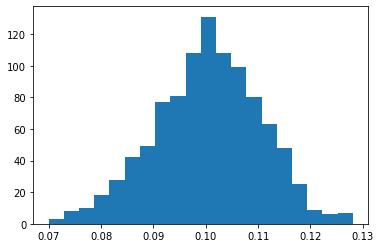

In [20]:
iterations = 1000
sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
plt.hist(sales_growth_dist, bins=20)
plt.show()

In [26]:
def run_mcs():
    
    # Create probability distributions
    sales_growth_dist = np.random.normal(loc=0.1, scale=0.01, size=iterations)
    ebitda_margin_dist = np.random.normal(loc=0.14, scale=0.02, size=iterations)
    nwc_percent_dist = np.random.normal(loc=0.24, scale=0.01, size=iterations)
    
    # Calculate DCF value for each set of random inputs
    output_distribution = []
    for i in range(iterations):
        for year in range(1, 7):
            sales[year] = sales[year - 1] * (1 + sales_growth_dist[0])
        ebitda = sales * ebitda_margin_dist[i]
        depreciation = (sales * depr_percent)
        ebit = ebitda - depreciation
        nwc = sales * nwc_percent_dist[i]
        change_in_nwc = nwc.shift(1) - nwc 
        capex = -(sales * capex_percent)
        tax_payment = -ebit * tax_rate
        tax_payment = tax_payment.apply(lambda x: min(x, 0))
        free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
        
        # DCF valuation
        terminal_value = (free_cash_flow[-1] * 1.02) / (cost_of_capital - 0.02)
        free_cash_flow[-1] += terminal_value
        discount_factors = [(1 / (1 + cost_of_capital)) ** i for i in range (1,7)]
        dcf_value = sum(free_cash_flow[1:] * discount_factors )
        output_distribution.append(dcf_value)
    
    return output_distribution

CPU times: user 3.31 s, sys: 8 ms, total: 3.32 s
Wall time: 3.3 s


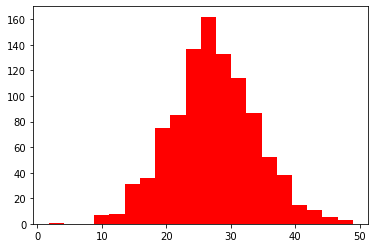

In [27]:
%time plt.hist(run_mcs(), bins=20, color='r')
plt.show()

In [29]:
years = 6
starting_sales = 31.0
capex_percent = depr_percent = 0.032
sales_growth = 0.1
ebitda_margin = 0.14
nwc_percent = 0.24
tax_rate = 0.25
# DCF assumptions
r = 0.12
g = 0.02
# For MCS model
iterations = 1000
sales_std_dev = 0.01
ebitda_std_dev = 0.02
nwc_std_dev = 0.01

In [33]:
def run_mcs():
    
    # Generate probability distributions
    sales_growth_dist = np.random.normal(loc=sales_growth, 
                                         scale=sales_std_dev, 
                                         size=(years, iterations))
    ebitda_margin_dist = np.random.normal(loc=ebitda_margin, 
                                          scale=ebitda_std_dev, 
                                          size=(years, iterations))
    nwc_percent_dist = np.random.normal(loc=nwc_percent, 
                                        scale=nwc_std_dev, 
                                        size=(years, iterations))
    
    # Calculate free cash flow
    sales_growth_dist += 1
    for i in range(1, len(sales_growth_dist)):
        sales_growth_dist[i] *= sales_growth_dist[i-1]
    sales = sales_growth_dist * starting_sales
    ebitda = sales * ebitda_margin_dist
    ebit = ebitda - (sales * depr_percent)
    tax = -(ebit * tax_rate)
    np.clip(tax, a_min=None, a_max=0)
    nwc = nwc_percent_dist * sales
    starting_nwc = starting_sales * nwc_percent
    prev_year_nwc = np.roll(nwc, 1, axis=0)
    prev_year_nwc[0] = starting_nwc
    delta_nwc = prev_year_nwc - nwc
    capex = -(sales * capex_percent)
    free_cash_flow = ebitda + tax + delta_nwc + capex
    # Discount cash flows to get DCF value
    terminal_value = free_cash_flow[-1] * (1 + g) / (r - g)
    discount_rates = [(1 / (1 + r)) ** i for i in range (1,7)]
    dcf_value = sum((free_cash_flow.T * discount_rates).T) 
    dcf_value += terminal_value * discount_rates[-1]
        
    return dcf_value

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 45.7 ms


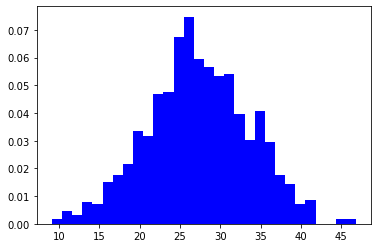

In [37]:
%time plt.hist(run_mcs(), bins=30, density=True, color="b")
plt.show()